Class Distribution in Original Data:
1    357
0    212
Name: count, dtype: int64

Class Distribution in Training Set (After Normalization):
1    286
0    169
Name: count, dtype: int64

Class Distribution in Testing Set (After Normalization):
1    71
0    43
Name: count, dtype: int64


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

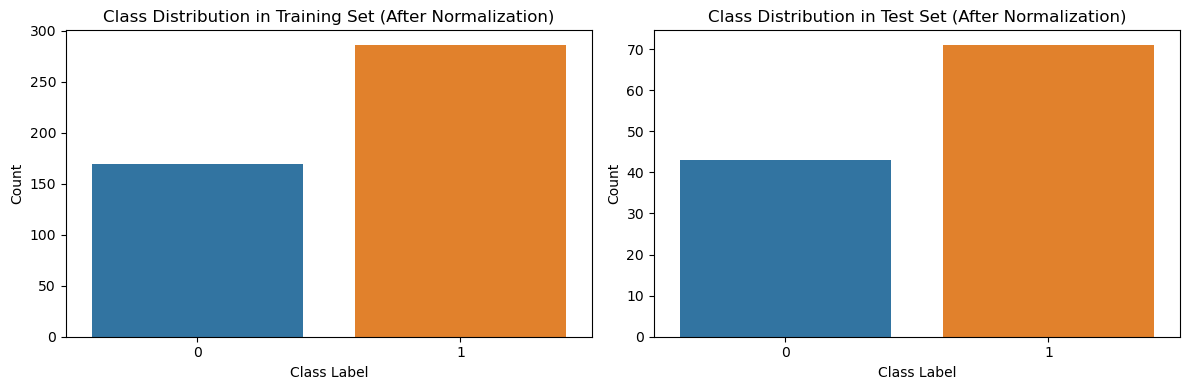

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, homogeneity_score, confusion_matrix, accuracy_score, adjusted_mutual_info_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
from sklearn.decomposition import FastICA
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Print class distribution before normalization
print("Class Distribution in Original Data:")
print(pd.Series(y).value_counts())

# Handling missing NaN values (replacing with mean)
X = np.nan_to_num(X)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing the data between 0 and 1
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Print class distribution after normalization
print("\nClass Distribution in Training Set (After Normalization):")
print(pd.Series(y_train).value_counts())

print("\nClass Distribution in Testing Set (After Normalization):")
print(pd.Series(y_test).value_counts())

# 4. Visualize class distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set (After Normalization)")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title("Class Distribution in Test Set (After Normalization)")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


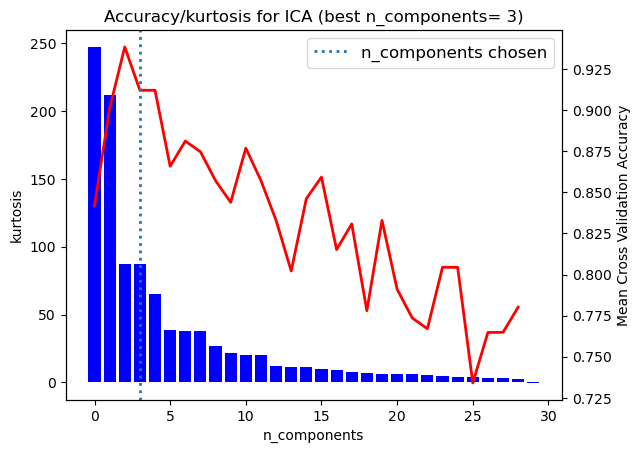

Calculating Reconstruction Error


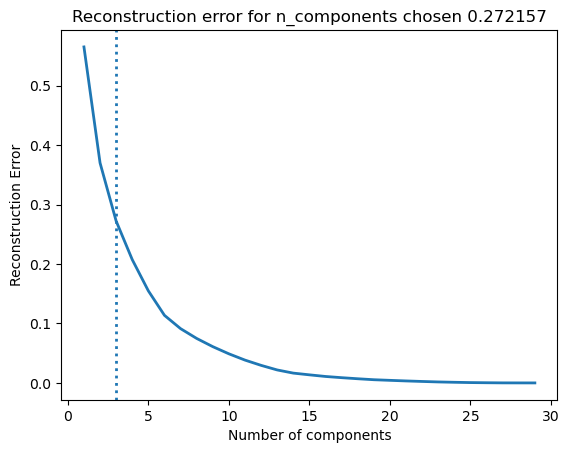

In [3]:
#Dimensionality reduction
def _calculate(X, ica_, n_components):
    components = ica_.components_
    ica_.components_ = components[:n_components]

    transformed = ica_.transform(X)
    ica_.components_ = components

    kurtosis = stats.kurtosis(transformed)

    return sorted(kurtosis, reverse=True)

# Initialize the DecisionTreeClassifier and FastICA
decisiontree = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)
ica = FastICA(random_state=42)

pipe = Pipeline(steps=[('ica', ica), ('decisionTree', decisiontree)])

# Fit the ICA on the training data
ica.fit(X_train)

fig, ax = plt.subplots()
ax.bar(np.arange(X_train.shape[1]), _calculate(X_train, ica, X_train.shape[1]), linewidth=2, color='blue')

plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('kurtosis')

# Checking the accuracy for taking all combination of components
n_components = range(1, X_train.shape[1])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components), cv=3)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_
ax1 = ax.twinx()

# Plotting the accuracies and best component
ax1.plot(results['mean_test_score'], linewidth=2, color='red')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth=2)

plt.legend(prop=dict(size=12))
plt.title('Accuracy/kurtosis for ICA (best n_components= %d)' % gridSearch.best_estimator_.named_steps['ica'].n_components)
plt.show()

# Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components=gridSearch.best_estimator_.named_steps['ica'].n_components, random_state=42)
ica_new.fit(X_train)
X_train_transformed = ica_new.transform(X_train)
X_test_transformed = ica_new.transform(X_test)

print("Calculating Reconstruction Error")

reconstruction_error = []
for comp in n_components:
    ica = FastICA(n_components=comp, random_state=42)
    X_transformed = ica.fit_transform(X_train)
    X_projected = ica.inverse_transform(X_transformed)
    reconstruction_error.append(((X_train - X_projected) ** 2).mean())

    if comp == gridSearch.best_estimator_.named_steps['ica'].n_components:
        chosen_error = ((X_train - X_projected) ** 2).mean()

fig2, ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth=2)
ax2.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f' % chosen_error)
plt.show()

In [4]:
# Train a Decision Tree on the original and ICA-transformed data
decision_tree_original = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)
decision_tree_ica = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)

# Fit the decision tree on the original data
decision_tree_original.fit(X_train, y_train)
y_pred_original = decision_tree_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
print(f'Accuracy of Original Data: {accuracy_original:.4f}')

# Fit the decision tree on the ICA-transformed data
decision_tree_ica.fit(X_train_transformed, y_train)
X_test_transformed = ica_new.transform(X_test)
y_pred_ica = decision_tree_ica.predict(X_test_transformed)
accuracy_ica = accuracy_score(y_test, y_pred_ica)
print(f'Accuracy for ICA Data: {accuracy_ica:.4f}')

# Print the reconstruction error for the chosen number of components
print(f'Reconstruction error for n_components chosen: {chosen_error:.6f}')

Accuracy of Original Data: 0.9386
Accuracy for ICA Data: 0.9211
Reconstruction error for n_components chosen: 0.272157


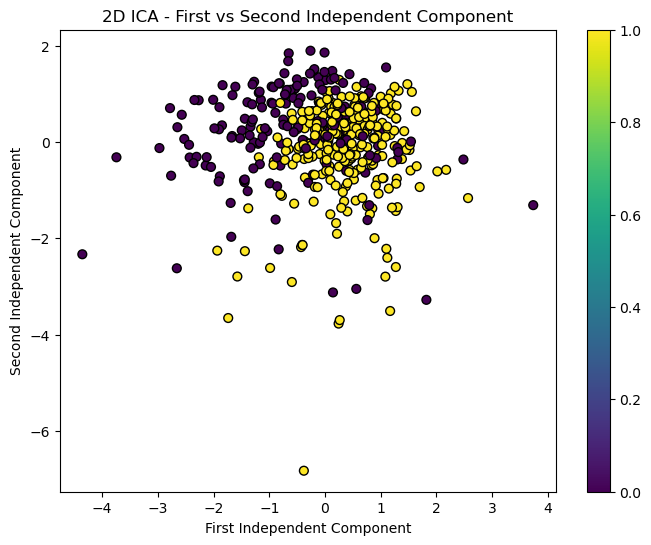

In [4]:
# 2D scatter plot for first two independent components
plt.figure(figsize=(8, 6))
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=40)
plt.title('2D ICA - First vs Second Independent Component')
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')
plt.colorbar()
plt.show()

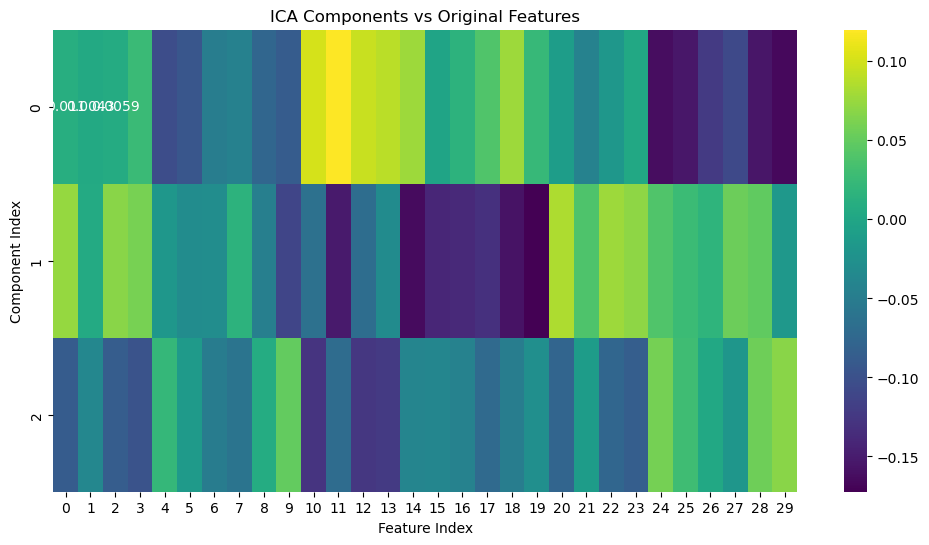

In [5]:
# Create heatmap for ICA components vs original features
ica_components = ica_new.components_
plt.figure(figsize=(12, 6))
sns.heatmap(ica_components, cmap='viridis', annot=True)
plt.title('ICA Components vs Original Features')
plt.xlabel('Feature Index')
plt.ylabel('Component Index')
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

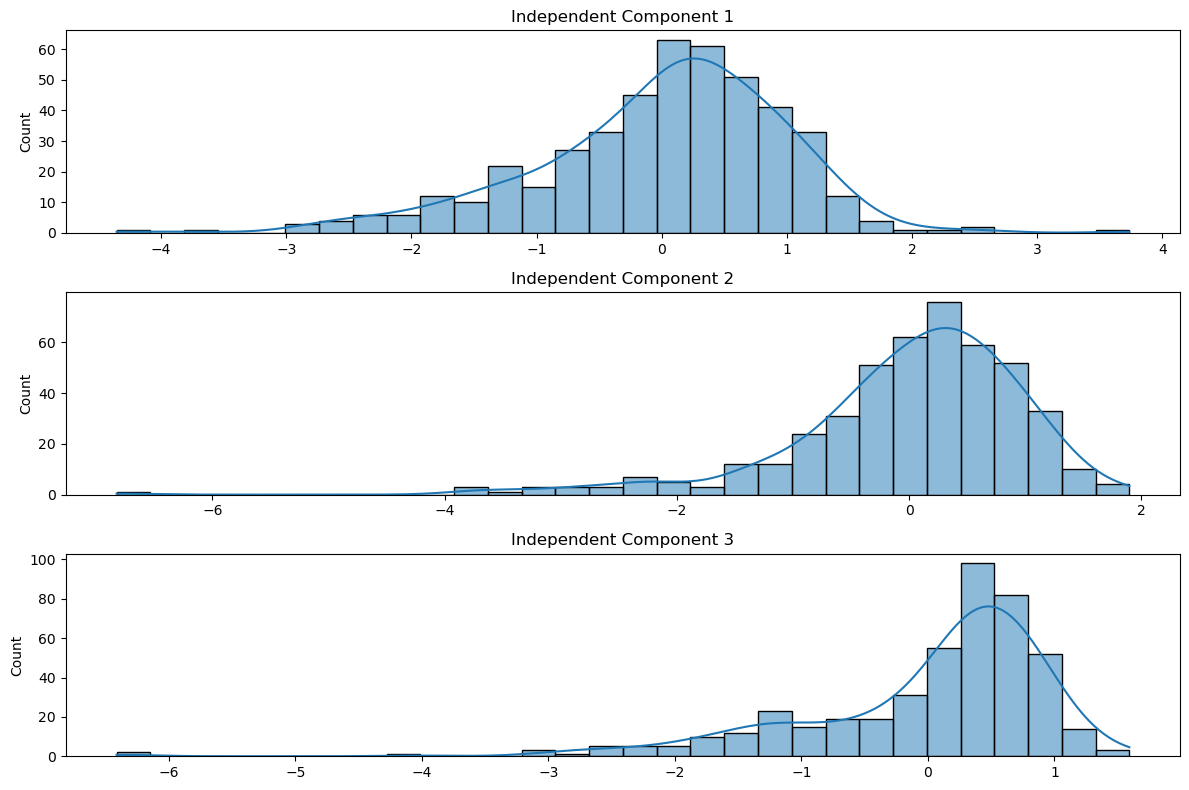

In [6]:
# Plot distributions of independent components
def plot_independent_components(X_ica):
    plt.figure(figsize=(12, 8))
    for i in range(X_ica.shape[1]):
        plt.subplot(X_ica.shape[1], 1, i + 1)
        sns.histplot(X_ica[:, i], kde=True, bins=30)
        plt.title(f'Independent Component {i+1}')
    plt.tight_layout()
    plt.show()

plot_independent_components(X_train_transformed)

In [5]:
# Apply ICA to the training data
ica = FastICA(n_components=3, random_state=42)  # for example, using 3 components
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)

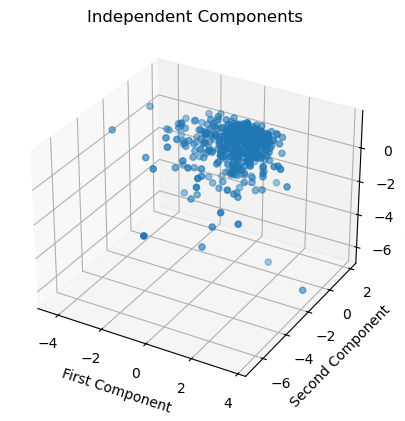

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a dataset with 3 ICA components
if X_train_ica.shape[1] >= 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_train_ica[:, 0], X_train_ica[:, 1], X_train_ica[:, 2])
    ax.set_title('Independent Components')
    ax.set_xlabel('First Component')
    ax.set_ylabel('Second Component')
    ax.set_zlabel('Third Component')
    plt.show()
elif X_train_ica.shape[1] == 2:
    plt.scatter(X_train_ica[:, 0], X_train_ica[:, 1])
    plt.title('Independent Components')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.show()
else:
    plt.hist(X_train_ica, bins=30)
    plt.title('Independent Components Distribution')
    plt.show()

In [7]:
#EM clustering

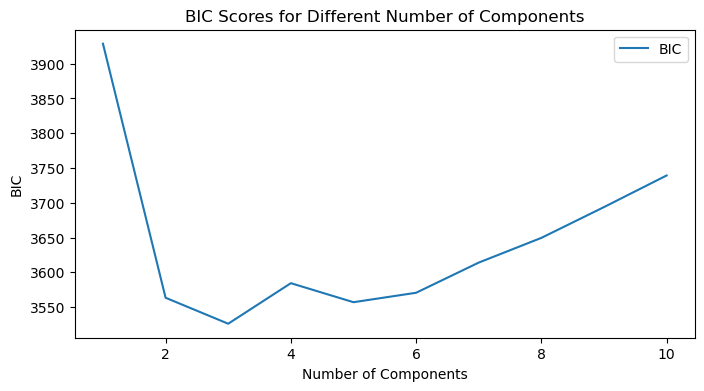

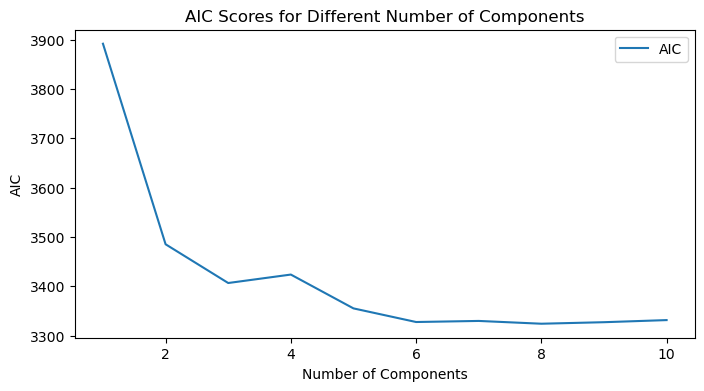

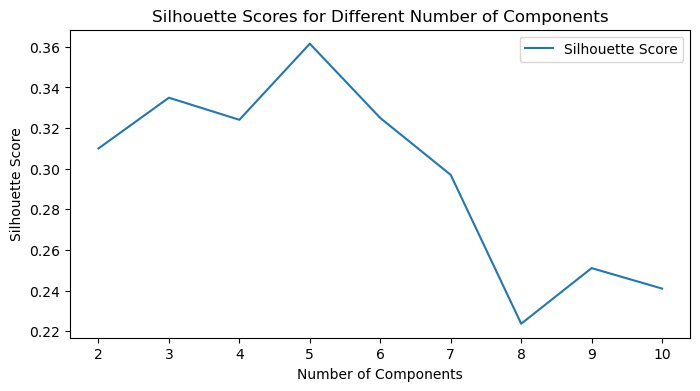

Optimal number of components according to BIC: 3
Silhouette Score for optimal number of components: 0.3350


In [8]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters for GMM
n_components_range = range(1, 11)  # Example: Trying 1 to 10 clusters
bic_scores = []
aic_scores = []
silhouette_scores = []

for n_components in n_components_range:
    # Initialize GaussianMixture with the current number of components
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    
    # Fit the model on the training data
    gmm.fit(X_train_transformed)
    
    # Calculate the Bayesian Information Criterion and Akaike Information Criterion
    bic_scores.append(gmm.bic(X_train_transformed))
    aic_scores.append(gmm.aic(X_train_transformed))
    
    # Predict clusters and calculate the silhouette score
    labels = gmm.predict(X_train_transformed)
    if n_components > 1:  # Silhouette score can only be computed with more than one cluster
        silhouette_scores.append(silhouette_score(X_train_transformed, labels))

# Plot BIC scores
plt.figure(figsize=(8, 4))
plt.plot(n_components_range, bic_scores, label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('BIC Scores for Different Number of Components')
plt.legend()
plt.show()

# Plot AIC scores
plt.figure(figsize=(8, 4))
plt.plot(n_components_range, aic_scores, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('AIC')
plt.title('AIC Scores for Different Number of Components')
plt.legend()
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(n_components_range[1:], silhouette_scores, label='Silhouette Score')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Number of Components')
plt.legend()
plt.show()

# Choose the number of components with the lowest BIC
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f'Optimal number of components according to BIC: {optimal_n_components}')

# Initialize and fit the GaussianMixture model with the optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm.fit(X_train_transformed)

# Predict the cluster labels
cluster_labels = gmm.predict(X_train_transformed)

# Evaluate the cluster quality
silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)
print(f'Silhouette Score for optimal number of components: {silhouette_avg:.4f}')

In [9]:
# Choose the number of components with the lowest BIC
optimal_n_components_bic = n_components_range[np.argmin(bic_scores)]
print(f'Optimal number of components according to BIC: {optimal_n_components_bic}')

# Choose the number of components with the highest silhouette score
optimal_n_components_silhouette = n_components_range[1:][np.argmax(silhouette_scores)]  # We offset by 1 due to silhouette range starting from 2
print(f'Optimal number of components according to Silhouette Score: {optimal_n_components_silhouette}')

# Choose the number of components with the lowest AIC
optimal_n_components_aic = n_components_range[np.argmin(aic_scores)]
print(f'Optimal number of components according to AIC: {optimal_n_components_aic}')

# Initialize and fit the GaussianMixture models with the optimal number of components according to each criterion
gmm_bic = GaussianMixture(n_components=optimal_n_components_bic, random_state=42)
gmm_bic.fit(X_train_transformed)

gmm_silhouette = GaussianMixture(n_components=optimal_n_components_silhouette, random_state=42)
gmm_silhouette.fit(X_train_transformed)

gmm_aic = GaussianMixture(n_components=optimal_n_components_aic, random_state=42)
gmm_aic.fit(X_train_transformed)

# Predict the cluster labels for each model
cluster_labels_bic = gmm_bic.predict(X_train_transformed)
cluster_labels_silhouette = gmm_silhouette.predict(X_train_transformed)
cluster_labels_aic = gmm_aic.predict(X_train_transformed)

# Evaluate the cluster quality using silhouette score for each model
silhouette_avg_bic = silhouette_score(X_train_transformed, cluster_labels_bic)
print(f'Silhouette Score for optimal number of components according to BIC: {silhouette_avg_bic:.4f}')

silhouette_avg_silhouette = silhouette_score(X_train_transformed, cluster_labels_silhouette)
print(f'Silhouette Score for optimal number of components according to Silhouette: {silhouette_avg_silhouette:.4f}')

silhouette_avg_aic = silhouette_score(X_train_transformed, cluster_labels_aic)
print(f'Silhouette Score for optimal number of components according to AIC: {silhouette_avg_aic:.4f}')


Optimal number of components according to BIC: 3
Optimal number of components according to Silhouette Score: 5
Optimal number of components according to AIC: 8
Silhouette Score for optimal number of components according to BIC: 0.3350
Silhouette Score for optimal number of components according to Silhouette: 0.3615
Silhouette Score for optimal number of components according to AIC: 0.2237


For n_clusters = 3, the average silhouette_score is : 0.3350


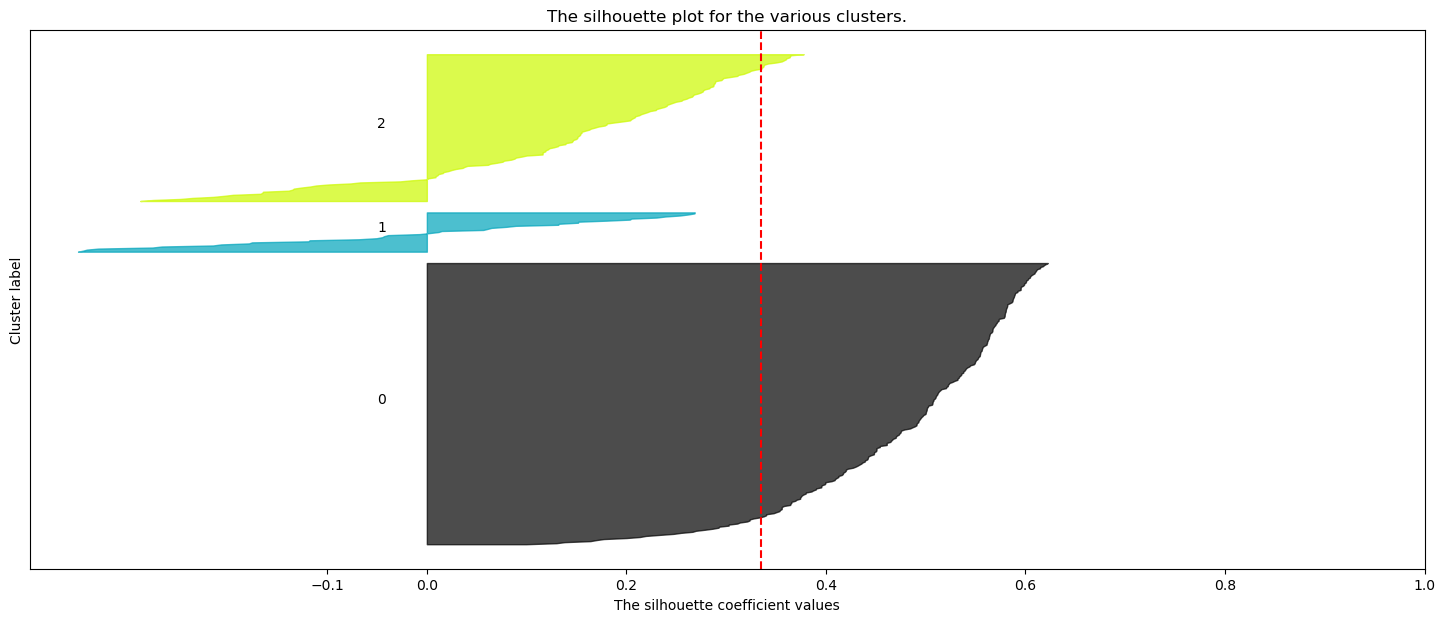

In [12]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

def silhouette_plot(X, cluster_labels, n_clusters, ax=None):
    if ax is None:
        ax = plt.gca()
    
    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10  # For space between silhouette plots of individual clusters
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Assuming you have calculated the optimal_n_components_bic already
optimal_n_components_bic = np.argmin(bic_scores) + 1  # Adding 1 because np.argmin will give index, not count
gmm_bic = GaussianMixture(n_components=optimal_n_components_bic, random_state=42)
gmm_bic.fit(X_train_transformed)
cluster_labels_bic = gmm_bic.predict(X_train_transformed)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# 1st subplot for the silhouette plot for BIC optimal number of clusters
silhouette_plot(X_train_transformed, cluster_labels_bic, optimal_n_components_bic, ax=ax1)
plt.show()



For n_clusters = 8, the average silhouette_score is : 0.2237


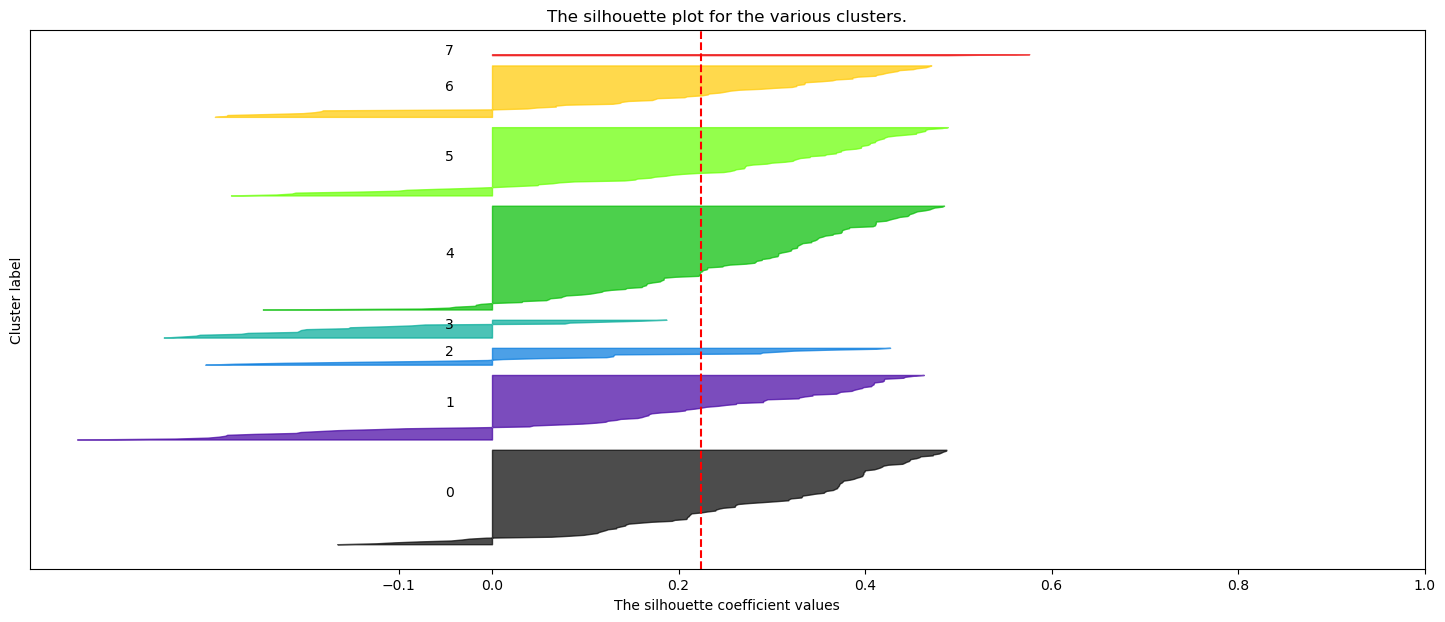

In [10]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

def silhouette_plot(X, cluster_labels, n_clusters, ax=None):
    if ax is None:
        ax = plt.gca()
    
    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10  # For space between silhouette plots of individual clusters
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Plotting silhouette scores for the optimal number of clusters according to AIC
gmm = GaussianMixture(n_components=optimal_n_components_aic, random_state=42)
gmm.fit(X_train_transformed)
cluster_labels = gmm.predict(X_train_transformed)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# 1st subplot for the silhouette plot
silhouette_plot(X_train_transformed, cluster_labels, optimal_n_components_aic, ax=ax1)
plt.show()


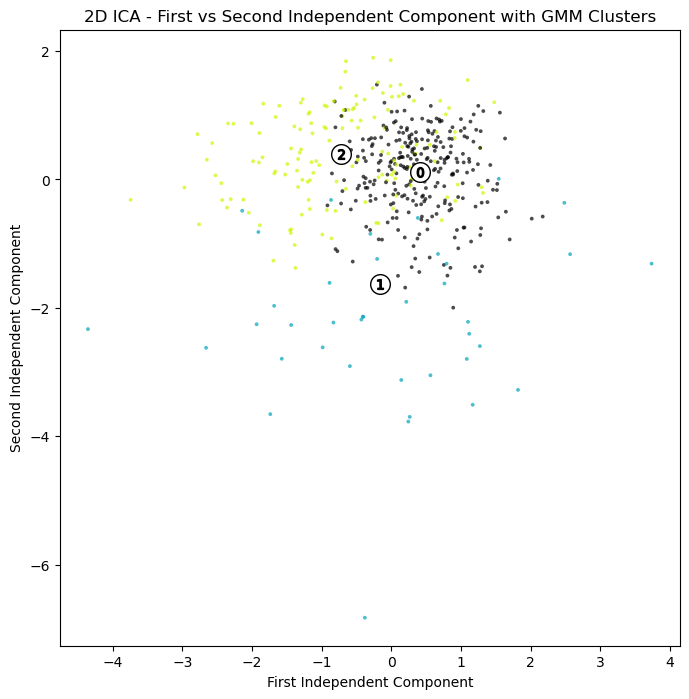

In [13]:
def plot_gmm_clusters(X, gmm, labels):
    plt.figure(figsize=(8, 8))
    colors = cm.nipy_spectral(labels.astype(float) / gmm.n_components)
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    # Plot the cluster centers
    centers = gmm.means_
    plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    plt.title(f'2D ICA - First vs Second Independent Component with GMM Clusters')
    plt.xlabel('First Independent Component')
    plt.ylabel('Second Independent Component')
    plt.show()

# Plotting the clusters
plot_gmm_clusters(X_train_transformed, gmm_bic, cluster_labels_bic)


In [14]:
#K-Means

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, silhouette score is 0.34365400367431986, SSE is 1028.9438733410916
For n_clusters = 3, silhouette score is 0.375971028739646, SSE is 793.3546169211127
For n_clusters = 4, silhouette score is 0.3776653071395588, SSE is 626.7978226521689
For n_clusters = 5, silhouette score is 0.28026185784761015, SSE is 550.2364123995685


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, silhouette score is 0.307738682311269, SSE is 486.1199574145429
For n_clusters = 7, silhouette score is 0.27077040359527377, SSE is 435.6245870258558
For n_clusters = 8, silhouette score is 0.2758582190592256, SSE is 388.6141388591738


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, silhouette score is 0.27899215273568617, SSE is 358.62488041834445
For n_clusters = 10, silhouette score is 0.2648405483485143, SSE is 334.52256071349063


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 11, silhouette score is 0.26118787630566076, SSE is 309.95813623557126
For n_clusters = 12, silhouette score is 0.25929300572791075, SSE is 291.66396283202994


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 13, silhouette score is 0.26458013260066643, SSE is 272.14468525058305
For n_clusters = 14, silhouette score is 0.24851816112161448, SSE is 262.73426418533495


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


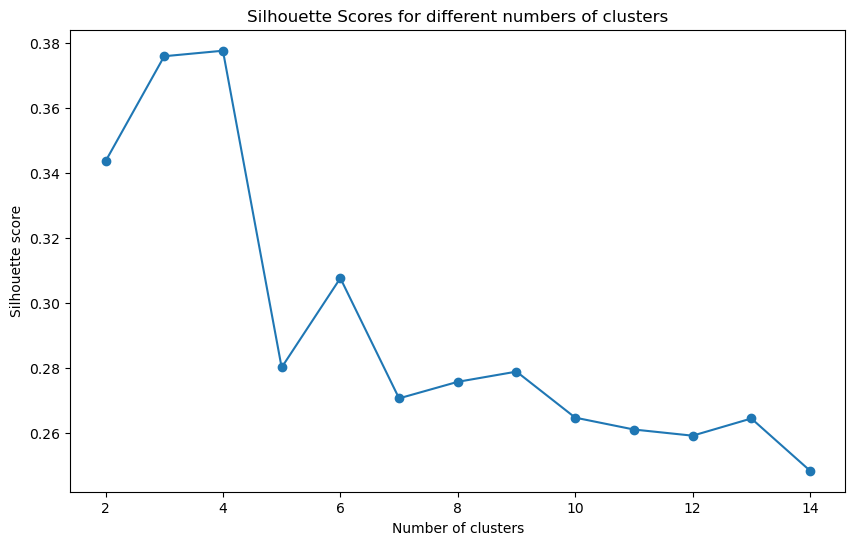

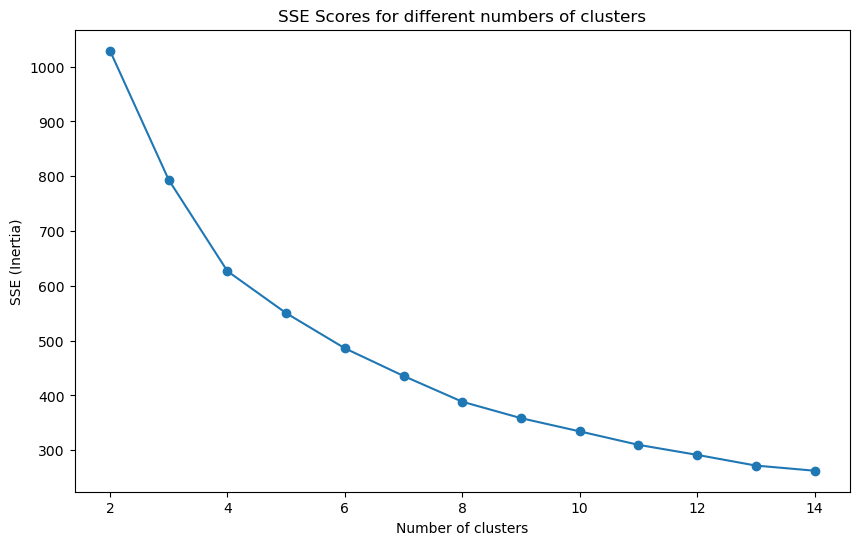

The optimal number of clusters based on silhouette score is: 4
The optimal number of clusters based on SSE is: 14


In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Choose a range for k
range_n_clusters = range(2, 15)

silhouette_avg_scores = []
sse_scores = []

for n_clusters in range_n_clusters:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_transformed)
    
    # Calculate SSE (inertia)
    sse_scores.append(kmeans.inertia_)
    
    # Predict the cluster for each data point
    cluster_labels = kmeans.predict(X_train_transformed)
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    
    print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_avg}, SSE is {kmeans.inertia_}")

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title('Silhouette Scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# Plot the SSE scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse_scores, marker='o')
plt.title('SSE Scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.show()

# Determine the optimal number of clusters based on silhouette score
optimal_n_clusters_silhouette = range_n_clusters[np.argmax(silhouette_avg_scores)]
print(f"The optimal number of clusters based on silhouette score is: {optimal_n_clusters_silhouette}")

# Determine the optimal number of clusters based on SSE
optimal_n_clusters_sse = range_n_clusters[np.argmin(sse_scores)]
print(f"The optimal number of clusters based on SSE is: {optimal_n_clusters_sse}")


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


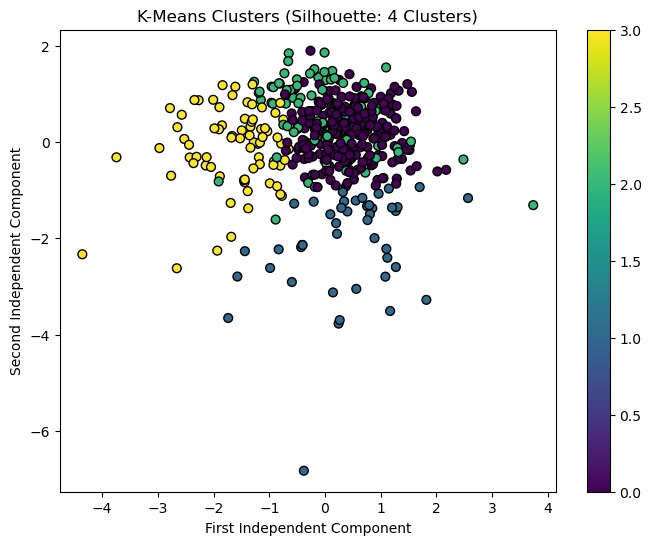

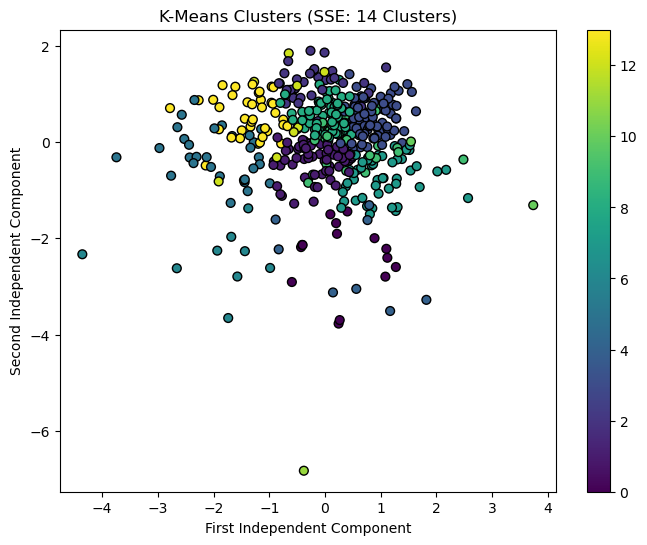

In [16]:
# Fit KMeans with the optimal number of clusters determined by silhouette score
kmeans_optimal_silhouette = KMeans(n_clusters=optimal_n_clusters_silhouette, random_state=42)
kmeans_optimal_silhouette.fit(X_train_transformed)
cluster_labels_optimal_silhouette = kmeans_optimal_silhouette.predict(X_train_transformed)

# Fit KMeans with the optimal number of clusters determined by SSE
kmeans_optimal_sse = KMeans(n_clusters=optimal_n_clusters_sse, random_state=42)
kmeans_optimal_sse.fit(X_train_transformed)
cluster_labels_optimal_sse = kmeans_optimal_sse.predict(X_train_transformed)

# Plotting 2D scatter plot for optimal clusters based on silhouette score
plt.figure(figsize=(8, 6))
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=cluster_labels_optimal_silhouette, cmap='viridis', edgecolor='k', s=40)
plt.title(f'K-Means Clusters (Silhouette: {optimal_n_clusters_silhouette} Clusters)')
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')
plt.colorbar()
plt.show()

# Plotting 2D scatter plot for optimal clusters based on SSE
plt.figure(figsize=(8, 6))
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=cluster_labels_optimal_sse, cmap='viridis', edgecolor='k', s=40)
plt.title(f'K-Means Clusters (SSE: {optimal_n_clusters_sse} Clusters)')
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')
plt.colorbar()
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

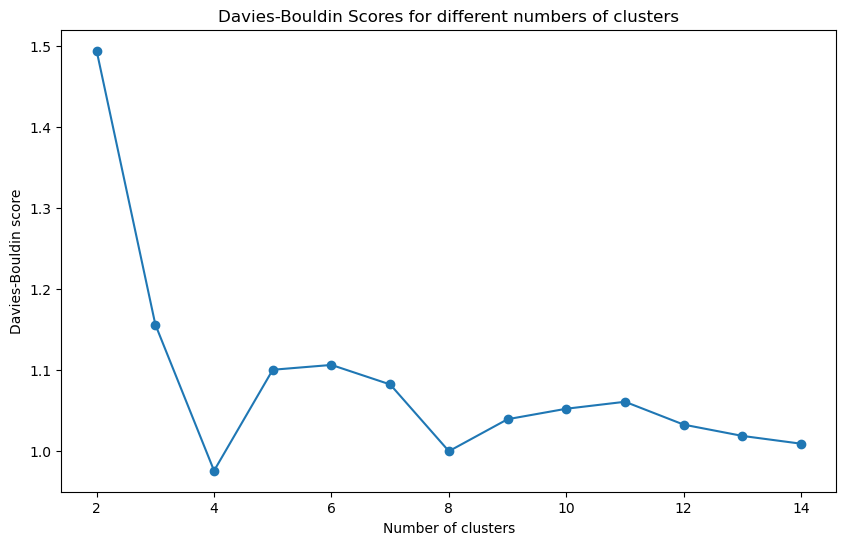

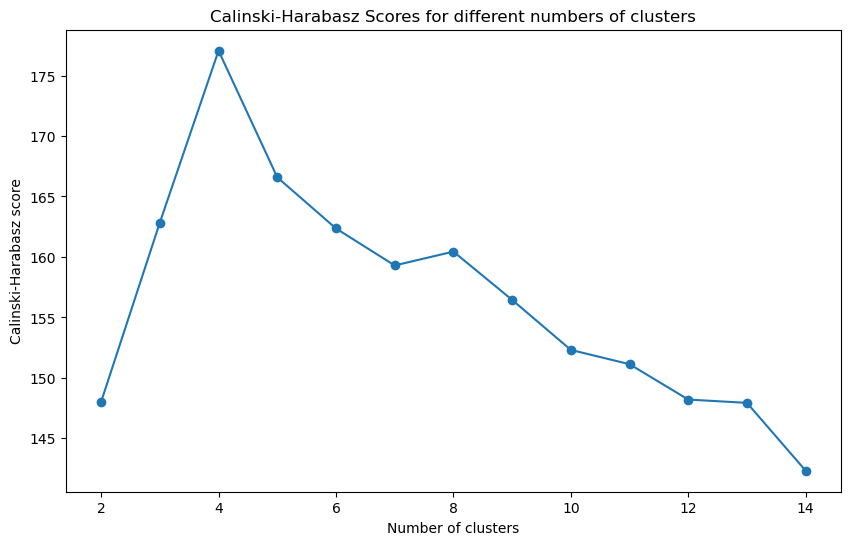

The optimal number of clusters based on Davies-Bouldin score is: 4
The optimal number of clusters based on Calinski-Harabasz score is: 4


In [17]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Additional Metrics
davies_bouldin_scores = []
calinski_harabasz_scores = []

for n_clusters in range_n_clusters:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_transformed)
    cluster_labels = kmeans.predict(X_train_transformed)
    
    # Calculate Davies-Bouldin scores
    db_score = davies_bouldin_score(X_train_transformed, cluster_labels)
    davies_bouldin_scores.append(db_score)
    
    # Calculate Calinski-Harabasz scores
    ch_score = calinski_harabasz_score(X_train_transformed, cluster_labels)
    calinski_harabasz_scores.append(ch_score)

# Plot the Davies-Bouldin scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin score')
plt.show()

# Plot the Calinski-Harabasz scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.show()

# Optimal number of clusters based on Davies-Bouldin score (the lower the better)
optimal_n_clusters_db = range_n_clusters[np.argmin(davies_bouldin_scores)]
print(f"The optimal number of clusters based on Davies-Bouldin score is: {optimal_n_clusters_db}")

# Optimal number of clusters based on Calinski-Harabasz score (the higher the better)
optimal_n_clusters_ch = range_n_clusters[np.argmax(calinski_harabasz_scores)]
print(f"The optimal number of clusters based on Calinski-Harabasz score is: {optimal_n_clusters_ch}")


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

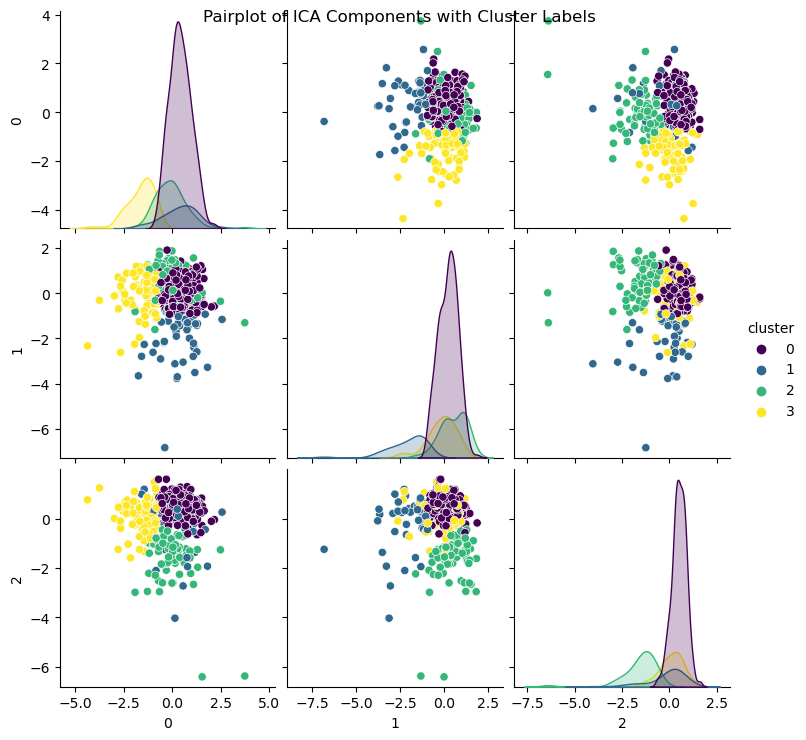

In [18]:
import seaborn as sns

# Use the cluster labels from the model with optimal clusters based on silhouette score
df_ica = pd.DataFrame(X_train_transformed)
df_ica['cluster'] = cluster_labels_optimal_silhouette

# Pairplot
sns.pairplot(df_ica, hue='cluster', palette='viridis')
plt.suptitle('Pairplot of ICA Components with Cluster Labels', verticalalignment='top')
plt.show()


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


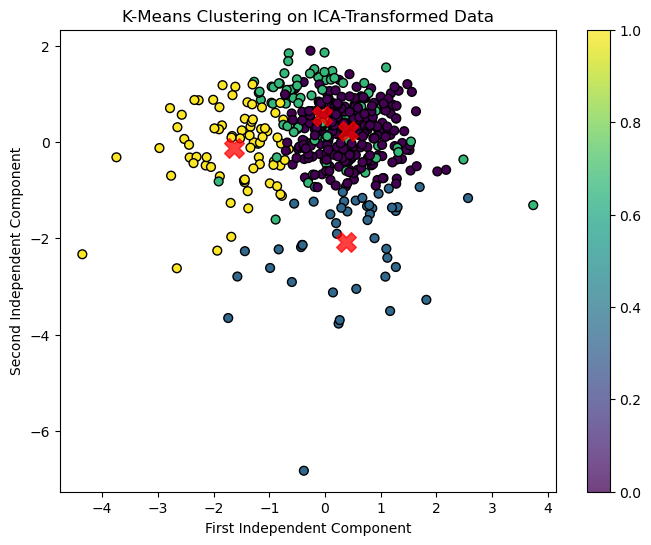

In [19]:
# Assuming you have the optimal number of clusters
optimal_n_clusters = 4
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
kmeans.fit(X_train_transformed)
cluster_labels = kmeans.predict(X_train_transformed)

# 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=40)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Means Clustering on ICA-Transformed Data')
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')
plt.colorbar()
plt.show()


In [22]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# Run K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_train_transformed)

# Map each cluster label to the true labels
labels = np.zeros_like(clusters)
for i in range(4):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

# Calculate the accuracy
accuracy = accuracy_score(y_train, labels)
print(f"Accuracy of K-Means with 4 clusters: {accuracy:.4f}")

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Assuming kmeans is already fitted with n_clusters=4 on the ICA-transformed data
# If not, you can fit it using:
# kmeans = KMeans(n_clusters=4, random_state=42)
# kmeans.fit(X_train_transformed)

# Assign the cluster labels to the data points
cluster_labels = kmeans.predict(X_train_transformed)

# Silhouette Score
silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)
print(f"Silhouette Score for 4 clusters: {silhouette_avg:.4f}")

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X_train_transformed, cluster_labels)
print(f"Calinski-Harabasz Index for 4 clusters: {calinski_harabasz:.4f}")

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X_train_transformed, cluster_labels)
print(f"Davies-Bouldin Index for 4 clusters: {davies_bouldin:.4f}")


Accuracy of K-Means with 4 clusters: 0.9099
Silhouette Score for 4 clusters: 0.3777
Calinski-Harabasz Index for 4 clusters: 177.0529
Davies-Bouldin Index for 4 clusters: 0.9753


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


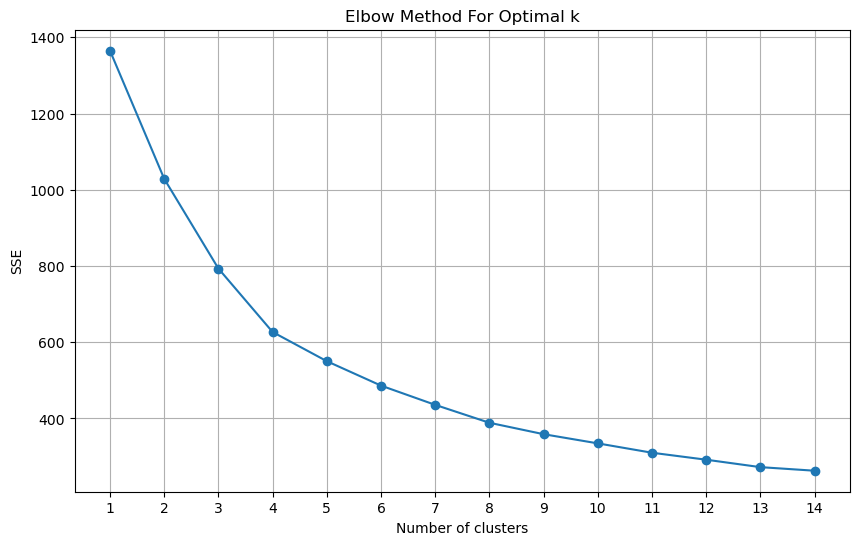

In [23]:
# KMeans sometimes converges to a local minimum. If you run it multiple times you might get slightly different results.
# To mitigate this, you can run KMeans with higher `n_init` which will run the algorithm with different centroid seeds and give you the best output.

sse = []  # Sum of squared distances of samples to their closest cluster center
for n_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(X_train_transformed)
    sse.append(kmeans.inertia_)  # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.xticks(range(1, 15))
plt.grid(True)
plt.show()


In [9]:
#NN

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


Accuracy with ICA-transformed data and best MLP model: 0.8246
Confusion Matrix:
 [[27 16]
 [ 4 67]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73        43
           1       0.81      0.94      0.87        71

    accuracy                           0.82       114
   macro avg       0.84      0.79      0.80       114
weighted avg       0.83      0.82      0.82       114



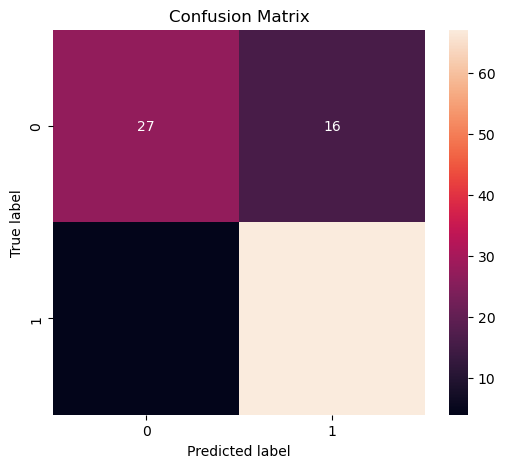

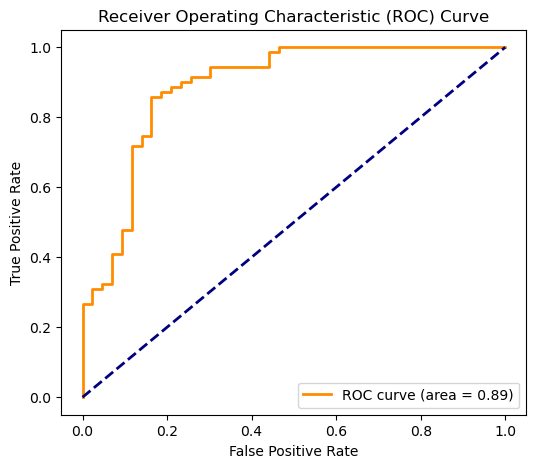

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FastICA
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import numpy as np

# Assume X_train, X_test, y_train, y_test are already defined

# Step 1: Initialize the components and pipeline with MLPClassifier
ica = FastICA(random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(10, 5), alpha=0.001, max_iter=3000, random_state=42, early_stopping=True)
pipe = Pipeline(steps=[('ica', ica), ('mlp', mlp)])

# Define the grid search parameters
n_components = [2, 10, 30]  # example components, adjust as necessary
gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components), cv=3)
gridSearch.fit(X_train, y_train)

# Step 2: Extract the best ICA transformer and the best MLP model from the grid search
best_ica_transformer = gridSearch.best_estimator_.named_steps['ica']
mlp_best = gridSearch.best_estimator_.named_steps['mlp']

# Transform the data
X_train_ica_best = best_ica_transformer.transform(X_train)
X_test_ica_best = best_ica_transformer.transform(X_test)

# Retrain the best MLP model (though it should already be trained from grid search)
mlp_best.fit(X_train_ica_best, y_train)

# Predict with the best estimator
y_pred = mlp_best.predict(X_test_ica_best)

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with ICA-transformed data and best MLP model: {accuracy:.4f}')

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

# Visualizations
# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# If the target variable is binary, we can also plot ROC curve
if len(np.unique(y_test)) == 2:
    y_score = mlp_best.predict_proba(X_test_ica_best)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

Accuracy with ICA-transformed data and MLP model: 0.3772
              precision    recall  f1-score   support

           0       0.38      1.00      0.55        43
           1       0.00      0.00      0.00        71

    accuracy                           0.38       114
   macro avg       0.19      0.50      0.27       114
weighted avg       0.14      0.38      0.21       114



/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


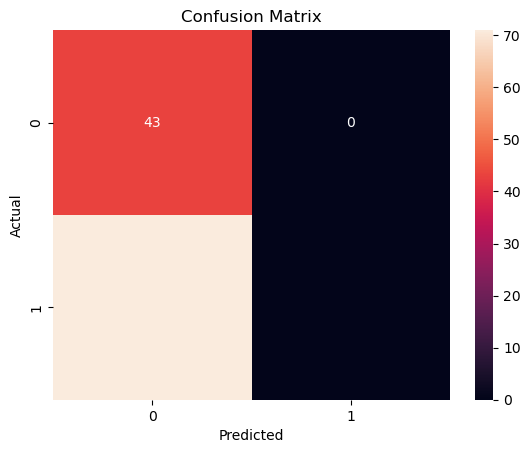

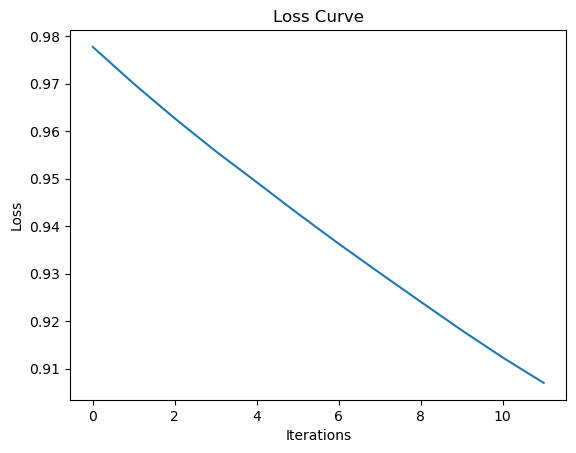

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Define the optimal number of ICA components
optimal_ica_components = 3

# Initialize ICA with the optimal number of components
ica = FastICA(n_components=optimal_ica_components, random_state=42)
ica.fit(X_train)

# Transform the data using the optimal ICA
X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)

# Initialize the MLPClassifier with early stopping
mlp = MLPClassifier(hidden_layer_sizes=(10, 5), alpha=0.001, max_iter=3000, random_state=42, early_stopping=True)

# Train the MLP with the ICA-transformed data
mlp.fit(X_train_ica, y_train)

# Predict with the trained MLP
y_pred = mlp.predict(X_test_ica)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with ICA-transformed data and MLP model: {accuracy:.4f}')

# Performance metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plotting the loss curve
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

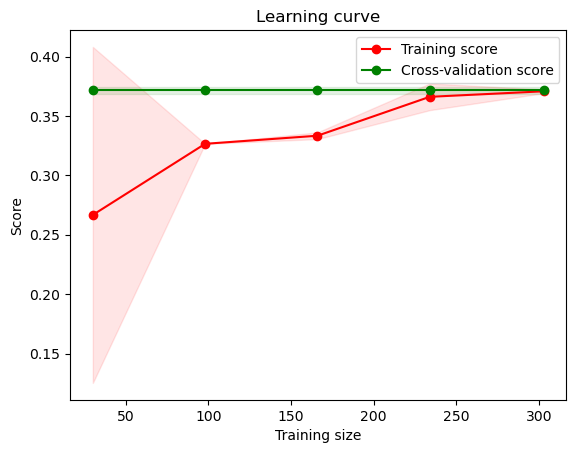

In [10]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    mlp, X_train_ica, y_train, cv=3, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="g", alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning curve')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()